# Introduction

### Problem Description

It is possible to liken ageing to a disease. If this analogy is accepted, one can develop it further and suggest that there be remedies for it. Such medicines are called geroprotectors. Being more rigorous, geroprotectors are drugs (or drug-like compounds) that slow down undesirable processes associated with ageing.

Species with Latin name *Caenorhabditis elegans* (nematode or roundworm in English) is an object of several experiments aimed to measure effect of different drugs on mean, median, and maximum lifespan. Below these experimental data are used and further in this presentation the word "geroprotector" means a compound that has positive impact on roundworms' lifespan.

The goal of the current study is to generate a list of compounds that are not marked as known geroprotectors, but with high probability are geroprotectors. In other words, the task is to extend given list of geroprotectors by finding new ones.

The methodology is quite similar to PU learning (positive-vs.-unlabeled learning). Unlike in the case of binary classification, there are no initially given negative examples — there are only positive and unlabeled examples (in this case, verified geroprotecors and random compounds respectively). However, we treat unlabeled examples as if they were negative. This leads to irrelevance of accuracy score, because labeling a negative example with positive label can be a mistake and can be a right decision. It is better to use ROC-AUC, since it depends only on examples' ranking by probability of belonging to the positive class. Also it is sometimes possible to weight classes in order to penalize false negatives heavier than false positives. It is shown that "in principle, the PU classification problem can be solved by a standard cost-sensitive classifier such as the weighted support vector machine" [2]. Finally, when classificator is built and predictions are made, negative examples with high estimated probability of positive label are delivered as new positive examples. 

The main limitation of the study is that only chemical features of compounds are involved. For example, some compounds are cures if concentration is low, but become poisonous if concentration is high. However, here concentration is not used. Features derived from interaction between a drug and an organism's cells are not used as well. Perhaps, this will be fixed in the future. 

### Data Sources

File *geroprotectors.csv* is based on Curated Database of Geroprotectors: http://geroprotectors.org/

File *zinc_smiles.csv* is based on ZINC Database: http://zinc.docking.org/browse/subsets/

### References

For more details on geroprotectors' search or PU learning please look at:

1. *Moskalev A, Zhavoronkov A, et al. In search for geroprotectors: in silico screening and in vitro validation of signalome-level mimetics of young healthy state. Aging (Albany NY). 2016*

2. *du Plessis M et al. Analysis of learning from positive and unlabeled data. NIPS'14 Proceedings of the 27th International Conference on Neural Information Processing Systems. 2014*

# Preparations

### General

In [1]:
from collections import OrderedDict
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Startup settings can not suppress a warning from XGBClassifier and so this is needed.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from xgboost import XGBClassifier

from rdkit.Chem import MolFromSmiles, rdMolDescriptors, Draw
from rdkit.DataStructs import ConvertToNumpyArray

In [2]:
np.random.seed(seed=361)

Of course, one can try any other random seed. Found peculiar seeds are as follows:
* 42 — one of the randomly chosen unlabeled SMILES can not be converted to fingerprint;
* 128500 — one of the randomly chosen unlabeled SMILES has the same fingerprint as a known geroprotector. 

### Data Extraction, Data Transformation, and Sanity Checkups

In [3]:
df = pd.read_csv('external_data/geroprotectors.csv', sep='\t')
df.head()

,Name,SMILES,Mean,Median,Max
0,Amoxapine,Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1,33.00,NaN,NaN
1,Amperozide Hydrochloride,Cl.CCNC(=O)N1CCN(CCCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1,38.00,NaN,NaN
2,Ascorbic Acid,OC[C@H](O)[C@H]1OC(=O)C(=C1O)O,66.67,NaN,NaN
3,Aspirin,CC(=O)Oc1ccccc1C(=O)O,23.00,NaN,NaN
4,Bacitracin,CC[C@H](C)[C@H](N)C1=N[C@@H](CS1)C(=O)N[C@@H](...,NaN,NaN,74.0


* Are there any duplicates?

In [4]:
len(df.index)

141

In [5]:
len(df['Name'].unique())

141

In [6]:
len(df['SMILES'].unique())

141

* How many compounds have more than one statistics measured?

In [7]:
len(df[pd.notnull(df['Mean']) & pd.notnull(df['Median']) & pd.notnull(df['Max'])])

2

In [8]:
len(df[pd.notnull(df['Mean']) & pd.notnull(df['Median'])])

5

In [9]:
len(df[pd.notnull(df['Median']) & pd.notnull(df['Max'])])

7

In [10]:
len(df[pd.notnull(df['Mean']) & pd.notnull(df['Max'])])

20

Hence, there is not enough data to predict values of one statistic from values of another statistic.

* Are there any abnormal values?

In [11]:
df.describe()

,Mean,Median,Max
count,123.000000,20.000000,28.000000
mean,22.850488,31.879500,31.574643
std,13.247925,19.306042,22.548757
min,3.100000,10.000000,0.100000
25%,13.000000,17.600000,12.067500
50%,19.000000,23.445000,26.100000
75%,31.500000,44.250000,49.750000
max,73.330000,70.000000,78.000000


* Let us convert SMILES to binary features.

In [12]:
def smiles_to_numpy(smiles, radius=2):
    """
    Takes Morgan fingerprints for each
    element of `smiles` and packs them
    to numpy array.
    
    Morgan fingerprints are chosen,
    because they provide fixed length
    of bit vectors.
    
    @type smiles: pandas.Series
    @type radius: integer
    @return: numpy.ndarray
    """
    molecules = map(MolFromSmiles, smiles.tolist())
    to_morgan = partial(rdMolDescriptors.GetMorganFingerprintAsBitVect,
                        radius=radius)
    fingerprints = map(to_morgan, molecules)
    
    # However, RDKit does not fit in functional paradigm.
    np_fingerprints = []
    for fingerprint in fingerprints:
        arr = np.zeros((1,))
        ConvertToNumpyArray(fingerprint, arr)
        np_fingerprints.append(arr)
    result = np.vstack(tuple(np_fingerprints))
    return result

In [13]:
geroprotectors = smiles_to_numpy(df['SMILES'])
geroprotectors.shape

(141, 2048)

* Now do the same for a random collection of molecules.

In [14]:
zinc_smiles = pd.read_csv('external_data/zinc_smiles.csv')
zinc_smiles.head()

,SMILES
0,c1ccc(cc1)C(c2ccccc2)[S@](=O)CC(=O)NO
1,CCC[S@](=O)c1ccc2c(c1)[nH]/c(=N\C(=O)OC)/[nH]2
2,c1c2c(cc3c1OCO3)[C@@H]4[C@H]([C@@H](C=C5[C@@H]...
3,C[C@@H](CC(c1ccccc1)(c2ccccc2)C(=O)N)[NH+](C)C
4,Cc1c(c(=O)n(n1C)c2ccccc2)NC(=O)[C@H](C)[NH+](C)C


In [15]:
random_indices = np.random.choice(np.arange(len(zinc_smiles.index)), size=5000, replace=False)
random_indices

array([749334, 718155, 345132, ..., 112431, 659212, 299060])

In [16]:
random_smiles = zinc_smiles.iloc[random_indices, :]
random_smiles.head()

,SMILES
749334,COc1ccc2c(c1)C(=O)NC[C@@]3(O2)CCCN(C3)C(=O)CCC...
718155,COc1ccc(cc1Cl)NC(=O)c2ccc(o2)C[NH3+]
345132,CC(=O)Nc1ccc2c(c1)[C@H]3C=CC[C@@H]3[C@@H](N2)c...
990997,c1cc(oc1)CC[C@@H](C[P@@H](=O)[O-])c2ccco2
605526,COc1ccc(cc1)CNC(=O)CCc2nc3ccccc3o2


In [17]:
len(random_smiles['SMILES'].unique())

5000

In [18]:
random_compounds = smiles_to_numpy(random_smiles['SMILES'])
random_compounds.shape

(5000, 2048)

* Are there any duplicates (not for SMILES, but for fingerprints)? Do samples overlap?

In [19]:
unique_gp = np.vstack({tuple(row) for row in geroprotectors}).shape[0]

try:
    assert unique_gp == geroprotectors.shape[0]
except AssertionError:
    print "# of duplicated fingerprints for geroprotectors: {}.".format(
        geroprotectors.shape[0] - unique_gp)
else:
    print "There are no duplicated fingerprints for geroprotectors."

There are no duplicated fingerprints for geroprotectors.


In [20]:
unique_rc = np.vstack({tuple(row) for row in random_compounds}).shape[0]

try:
    assert unique_rc == random_compounds.shape[0]
except AssertionError:
    print "# of duplicated fingerprints for random compounds: {}.".format(
        random_compounds.shape[0] - unique_rc)
else:
    print "There are no duplicated fingerprints for random compounds."

# of duplicated fingerprints for random compounds: 11.


In [21]:
unique_all = np.vstack({tuple(row)
                        for row in np.vstack((geroprotectors, random_compounds))}).shape[0]

try:
    assert unique_all == unique_gp + unique_rc
except AssertionError:
    print "Length of intersection between two samples: {}.".format(
        unique_gp + unique_rc - unique_all)
else:
    print "There is no intersection between geroprotectors and random compounds."

There is no intersection between geroprotectors and random compounds.


Although `random_compounds` has duplicate fingerprints (e.g. due to hash collisions turning different SMILES into the same fingerprint), there is an empty intersection between randomly chosen compounds and known geroprotectors.

* Finally, gather samples together and introduce the target variable.

In [22]:
positives = np.hstack((geroprotectors, np.ones((geroprotectors.shape[0], 1))))
negatives = np.hstack((random_compounds, np.zeros((random_compounds.shape[0], 1))))
sample = np.vstack((positives, negatives))
sample.shape

(5141, 2049)

In [23]:
border = positives.shape[0]

# Exploratory Analysis

### Single Bits Importance

Below hypothesis that some bits of fingerprints allows separating geroprotectors, is tested.

In [24]:
scores = {}
for i in range(sample.shape[1] - 1):
    scores[i] = roc_auc_score(sample[:, -1], sample[:, i])

In [25]:
n_to_print = 10
for position in sorted(scores, key=scores.get, reverse=True)[:n_to_print]:
    print "Bit position: {}, ROC-AUC: {}".format(position, scores[position])

Bit position: 1602, ROC-AUC: 0.587775177305
Bit position: 1607, ROC-AUC: 0.57365248227
Bit position: 389, ROC-AUC: 0.565090070922
Bit position: 1844, ROC-AUC: 0.557883687943
Bit position: 352, ROC-AUC: 0.556360283688
Bit position: 1979, ROC-AUC: 0.555337588652
Bit position: 1538, ROC-AUC: 0.555237588652
Bit position: 1257, ROC-AUC: 0.553629787234
Bit position: 222, ROC-AUC: 0.553275886525
Bit position: 1171, ROC-AUC: 0.551990780142


In [26]:
for position in sorted(scores, key=scores.get)[:n_to_print]:
    print "Bit position: {}, ROC-AUC: {}".format(position, scores[position])

Bit position: 1152, ROC-AUC: 0.321375177305
Bit position: 378, ROC-AUC: 0.350321985816
Bit position: 1917, ROC-AUC: 0.363258156028
Bit position: 1816, ROC-AUC: 0.373992198582
Bit position: 1057, ROC-AUC: 0.385465248227
Bit position: 1750, ROC-AUC: 0.393533333333
Bit position: 1722, ROC-AUC: 0.39729929078
Bit position: 650, ROC-AUC: 0.399125531915
Bit position: 1873, ROC-AUC: 0.415270921986
Bit position: 1380, ROC-AUC: 0.41904751773


After reverting predictions ROC-AUC over 67% is reached solely by feature 1152 for all tested random seeds. They are as follows: 19, 26, 44, 123, 187, 361, 638, 1001, 3249, 128500.

In [27]:
np.mean(positives[:, 1152])

0.22695035460992907

In [28]:
np.mean(negatives[:, 1152])

0.58420000000000005

Thus, there is no silver bullet amongst the features, but there are relationships between the target and the features.

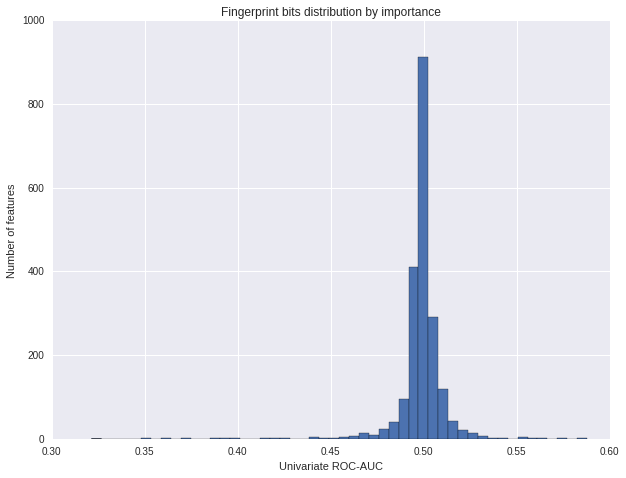

In [29]:
fig = plt.figure(figsize=(10, 7.5))
ax = fig.add_subplot(111)
ax.set_title("Fingerprint bits distribution by importance")
ax.set_xlabel("Univariate ROC-AUC")
ax.set_ylabel("Number of features")
_ = ax.hist([scores[key] for key in scores.keys()], 50)

More than half of the features seem like they are of little use. The next section surveys effect of their removal as well as some other issues.

### Similarities' Study

In [30]:
def take_balanced_subsample(iterable, size):
    """
    For each element of `iterable` draws
    `size` objects (i.e. lines) from it and then
    concatenates the results.
    
    @type iterable: list-like of numpy.ndarray
    @type size: integer
    @type: numpy.ndarray
    """
    subsamples = []
    for arr in iterable:
        subsample = arr[np.random.choice(np.arange(arr.shape[0]), size=size, replace=False), :]
        subsamples.append(subsample)
    return np.vstack(tuple(subsamples))

In [31]:
def tanimoto_similarity(first, second):
    """
    Computes Tanimoto similarity of two arrays.
    
    It is defined as a ratio of number of bits
    active in both arrays to number of bits
    active in at least one array.
    
    @type first: numpy.ndarray
    @type second: numpy.ndarray
    @return: float
    """
    bool_first = first.astype(bool)
    bool_second = second.astype(bool)
    intersection_length = np.sum(np.bitwise_and(bool_first, bool_second).astype(int))
    union_length = np.sum(np.bitwise_or(bool_first, bool_second).astype(int))
    return float(intersection_length) / union_length

In [32]:
def fill_tanimoto_matrix(arr):
    """
    Assuming that each line of `arr` represents
    an object, fills matrix of pairwise
    Tanimoto similarities.
    
    @type arr: numpy.ndarray
    @return: numpy.ndarray
    """
    size = arr.shape[0]
    tanimoto_matrix = np.zeros((size, size))
    for i, j in product(range(size), range(size)):
        tanimoto_matrix[i, j] = tanimoto_similarity(arr[i, :], arr[j, :])
    return tanimoto_matrix

In [33]:
halfsize = 10
subsample = take_balanced_subsample([positives, negatives], halfsize)[:, :-1]
tanimoto_matrix = fill_tanimoto_matrix(subsample)

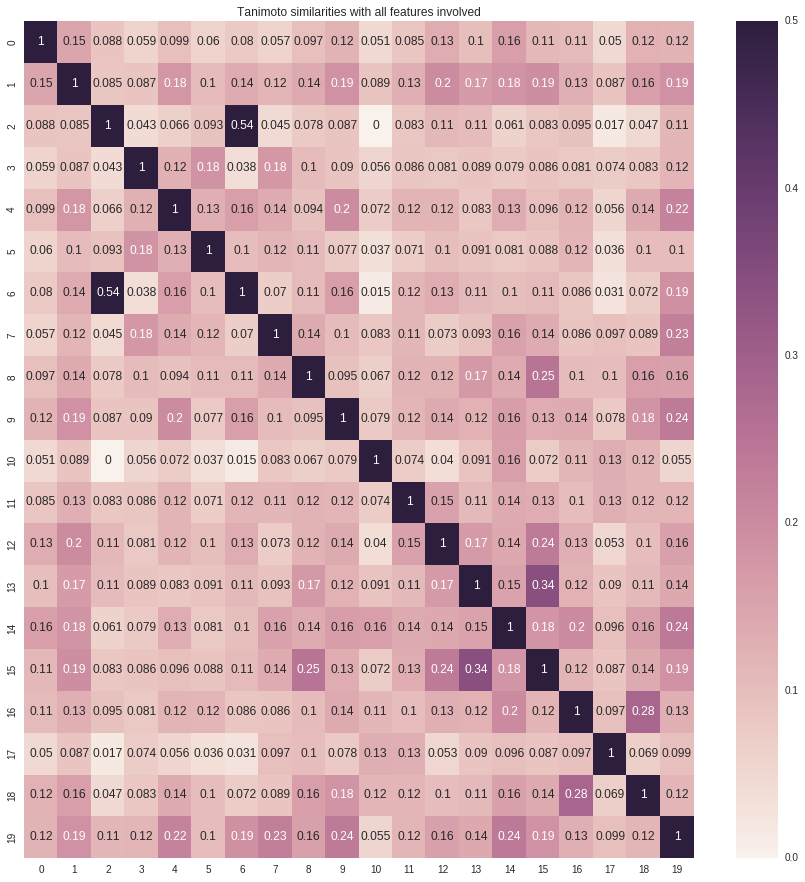

In [34]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_title("Tanimoto similarities with all features involved")
_ = sns.heatmap(tanimoto_matrix, ax=ax, annot=True, vmax=0.5)

In [35]:
relevant_features = [key for key in scores.keys() if abs(scores[key] - 0.5) > 0.01]
subspaced_subsample = subsample[:, relevant_features]
subspaced_tanimoto_matrix = fill_tanimoto_matrix(subspaced_subsample)

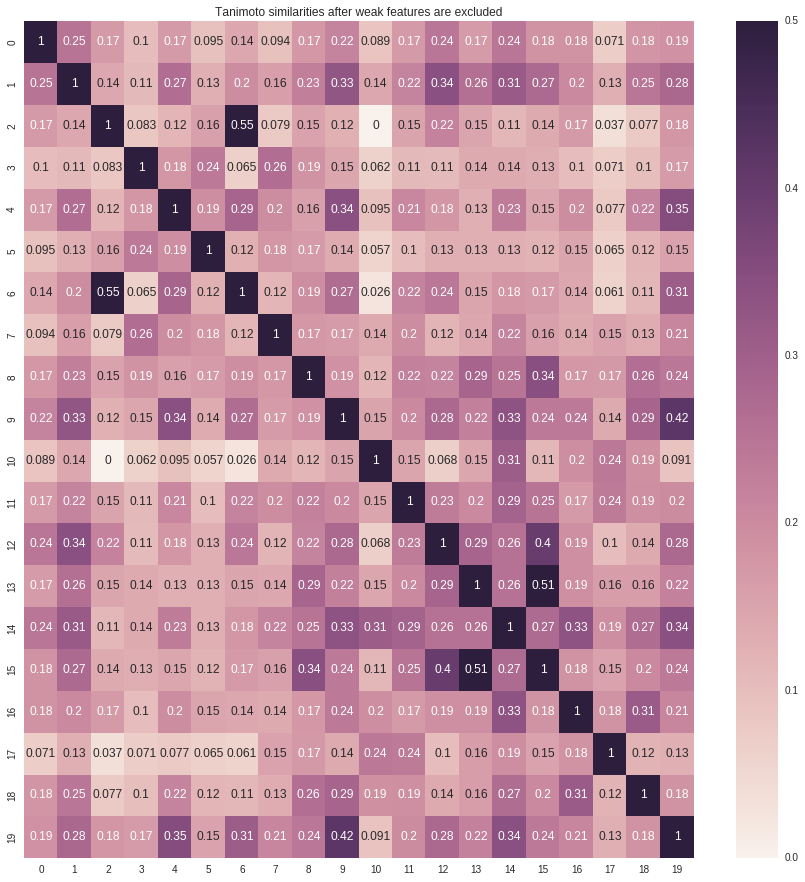

In [36]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_title("Tanimoto similarities after weak features are excluded")
_ = sns.heatmap(subspaced_tanimoto_matrix, ax=ax, annot=True, vmax=0.5)

It can be seen that removal of weak features makes compounds more similar to each other.

Also it is clear from the heatmaps that known geroprotectors are dissimilar to each other approximately at the same extent as they are dissimilar to random compounds.

### Dimensionality Reduction

The trick applied here is that instead of dropping irrelevant features all features are weighted according to their relevance. If features are binary, PCA treats all of them as equally important, but suggested trick solves this issue.

In [37]:
weights = np.array([abs(scores[key] - 0.5) for key in scores.keys()])
weighted_positives = positives[:, :-1] * weights
weighted_negatives = negatives[:, :-1] * weights
weighted_sample = sample[:, :-1] * weights

In [38]:
pca = PCA(n_components=10, random_state=361)
pca.fit(weighted_sample)
pca.explained_variance_ratio_

array([ 0.249474  ,  0.13769388,  0.0764098 ,  0.06983147,  0.05185634,
        0.03839376,  0.03516741,  0.03218909,  0.02282965,  0.01813438])

In [39]:
pca = PCA(n_components=1, random_state=361)
roc_auc_score(sample[:, -1], pca.fit_transform(weighted_sample)[:, 0])

0.72270070921985818

In [40]:
pca = PCA(n_components=3, random_state=361)
pca.fit(weighted_sample)
pcaed_positives = pca.transform(weighted_positives)
pcaed_negatives = pca.transform(weighted_negatives)

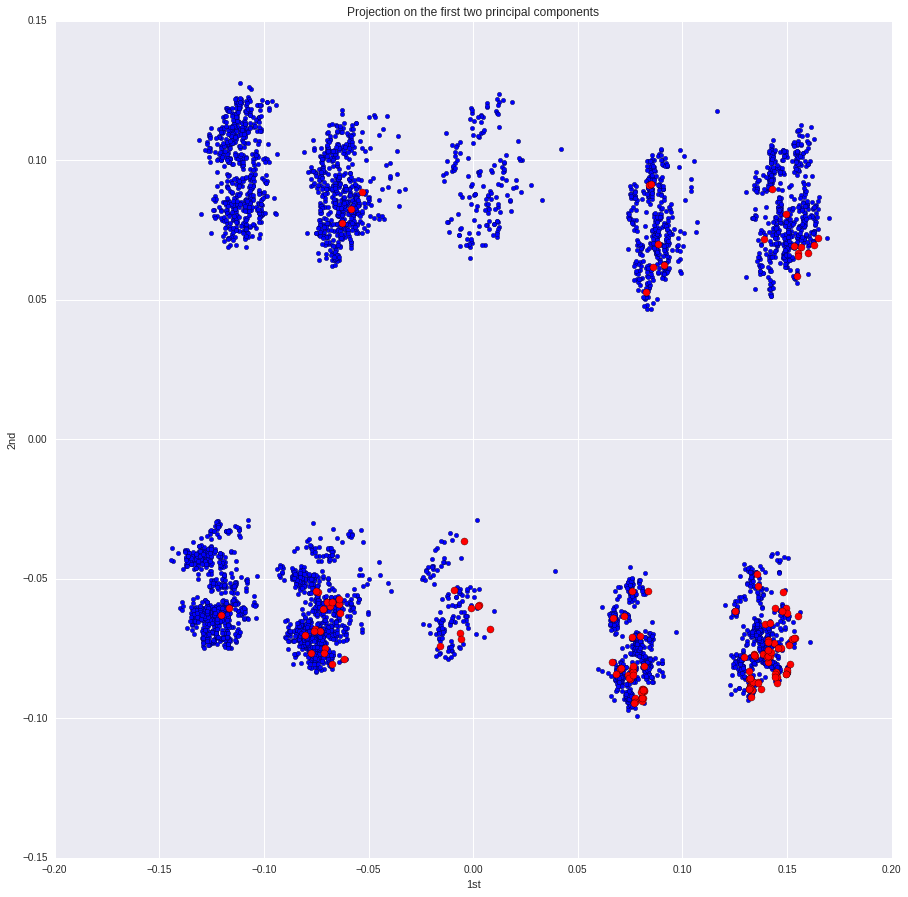

In [41]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_title("Projection on the first two principal components")
ax.set_xlabel("1st")
ax.set_ylabel("2nd")
ax.scatter(pcaed_negatives[:, 0], pcaed_negatives[:, 1])
_ = ax.scatter(pcaed_positives[:, 0], pcaed_positives[:, 1], c='Red', s=50)

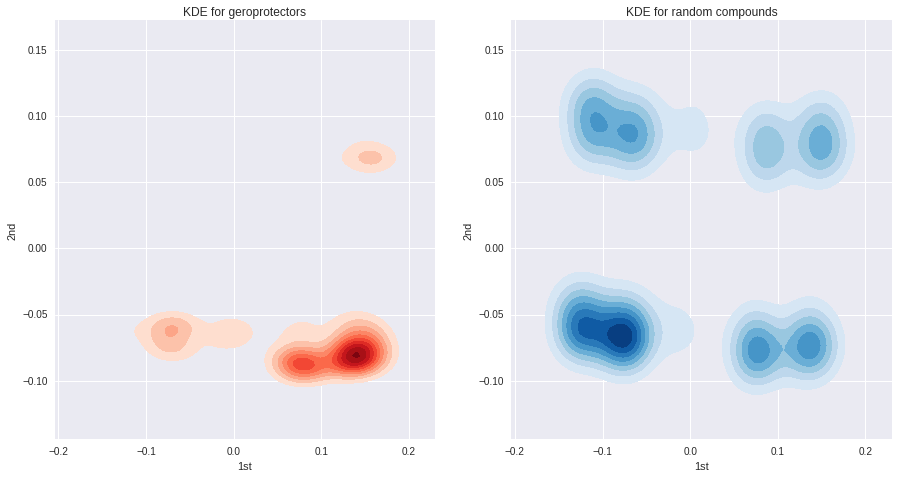

In [42]:
fig = plt.figure(figsize=(15, 7.5))
ax_one = fig.add_subplot(121)
ax_one.set_title("KDE for geroprotectors")
ax_one.set_xlabel("1st")
ax_one.set_ylabel("2nd")
sns.kdeplot(pcaed_positives[:, 0], pcaed_positives[:, 1],
            cmap='Reds', shade=True, shade_lowest=False, ax=ax_one)
ax_two = fig.add_subplot(122, sharex=ax_one, sharey=ax_one)
ax_two.set_title("KDE for random compounds")
ax_two.set_xlabel("1st")
ax_two.set_ylabel("2nd")
_ = sns.kdeplot(pcaed_negatives[:, 0], pcaed_negatives[:, 1],
            cmap='Blues', shade=True, shade_lowest=False, ax=ax_two)

Above graph can be used for extending the list of geroprotectors. There is a hypothesis that solid ratio of random compounds from the bottom right cluster (i.e. the one with center at (0.13, -0.07)), are geroprotectors. This hypothesis seems very plausible.

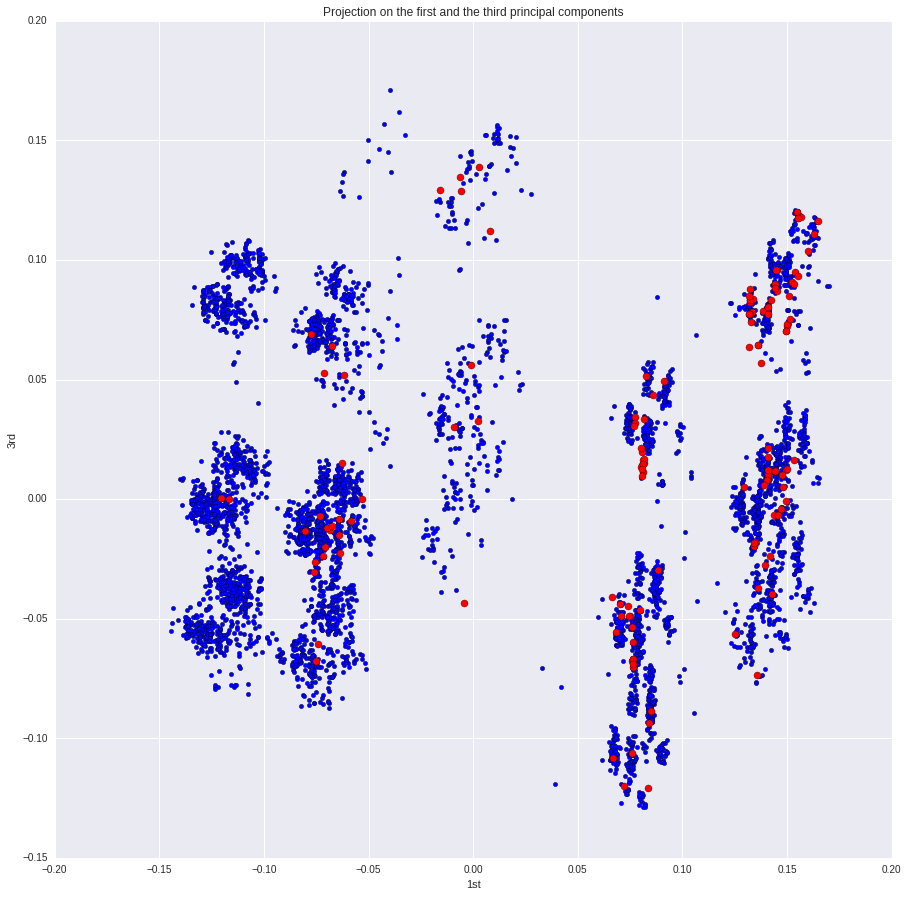

In [43]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_title("Projection on the first and the third principal components")
ax.set_xlabel("1st")
ax.set_ylabel("3rd")
ax.scatter(pcaed_negatives[:, 0], pcaed_negatives[:, 2])
_ = ax.scatter(pcaed_positives[:, 0], pcaed_positives[:, 2], c='Red', s=50)

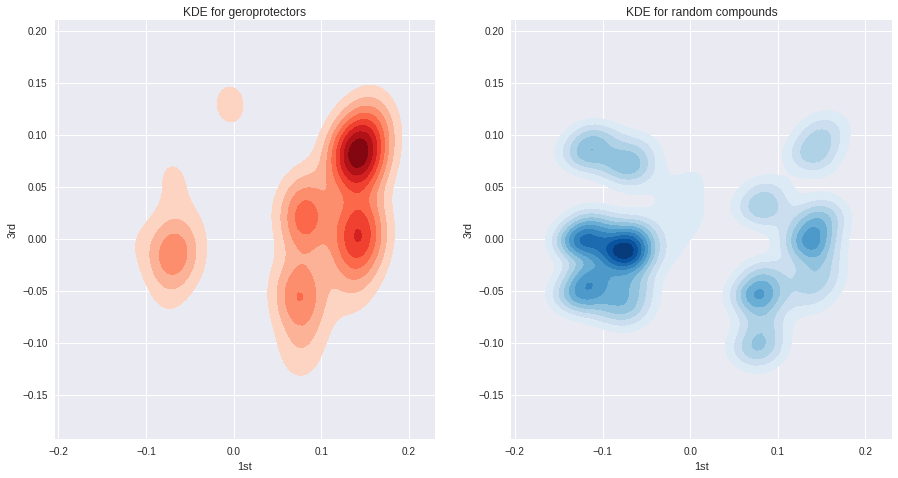

In [44]:
fig = plt.figure(figsize=(15, 7.5))
ax_one = fig.add_subplot(121)
ax_one.set_title("KDE for geroprotectors")
ax_one.set_xlabel("1st")
ax_one.set_ylabel("3rd")
sns.kdeplot(pcaed_positives[:, 0], pcaed_positives[:, 2],
            cmap='Reds', shade=True, shade_lowest=False, ax=ax_one)
ax_two = fig.add_subplot(122, sharex=ax_one, sharey=ax_one)
ax_two.set_title("KDE for random compounds")
ax_two.set_xlabel("1st")
ax_two.set_ylabel("3rd")
_ = sns.kdeplot(pcaed_negatives[:, 0], pcaed_negatives[:, 2],
            cmap='Blues', shade=True, shade_lowest=False, ax=ax_two)

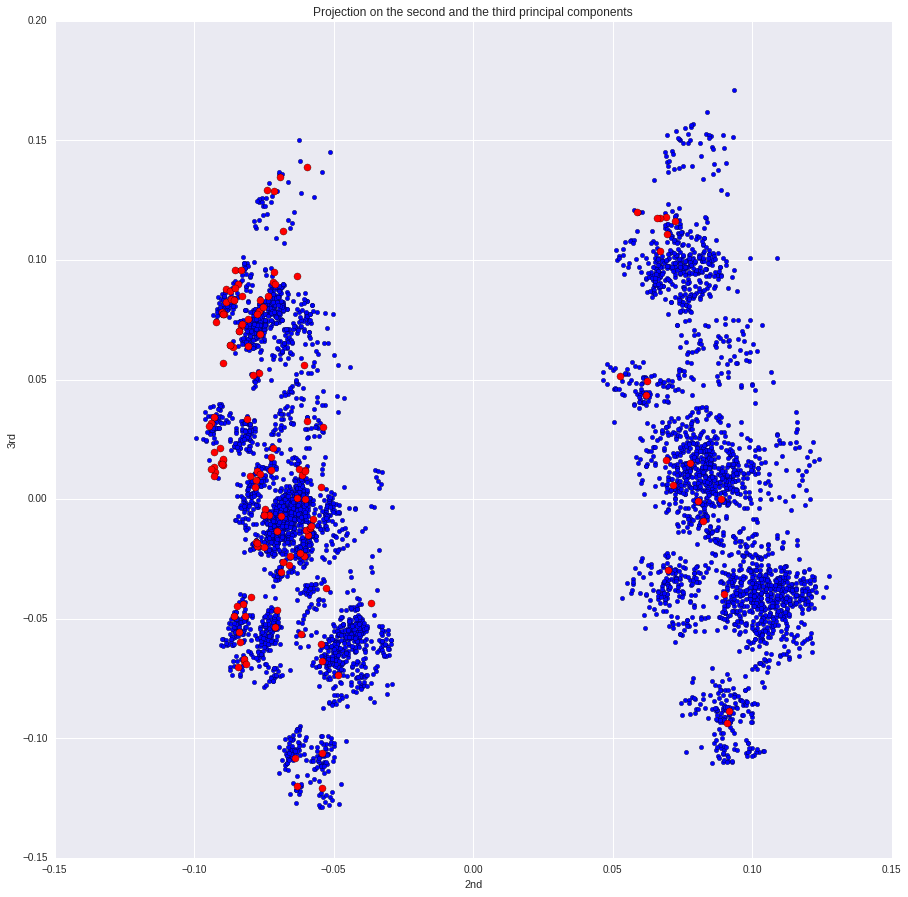

In [45]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_title("Projection on the second and the third principal components")
ax.set_xlabel("2nd")
ax.set_ylabel("3rd")
ax.scatter(pcaed_negatives[:, 1], pcaed_negatives[:, 2])
_ = ax.scatter(pcaed_positives[:, 1], pcaed_positives[:, 2], c='Red', s=50)

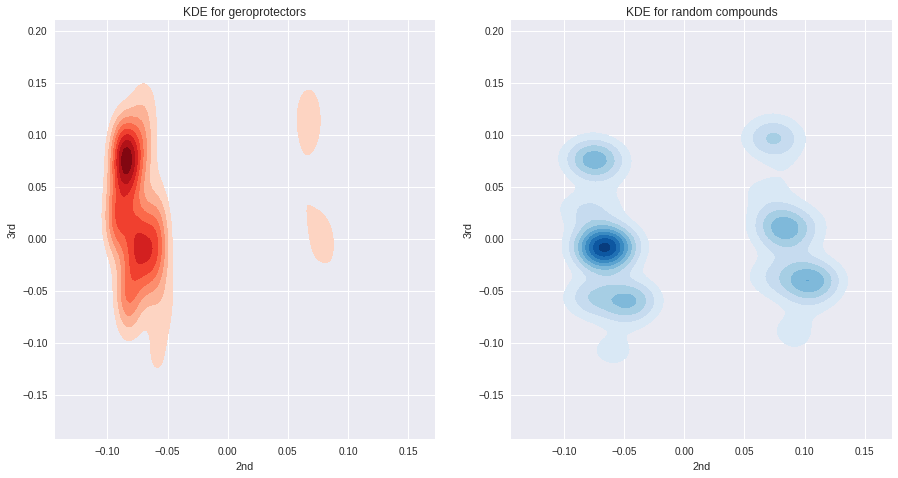

In [46]:
fig = plt.figure(figsize=(15, 7.5))
ax_one = fig.add_subplot(121)
ax_one.set_title("KDE for geroprotectors")
ax_one.set_xlabel("2nd")
ax_one.set_ylabel("3rd")
sns.kdeplot(pcaed_positives[:, 1], pcaed_positives[:, 2],
            cmap='Reds', shade=True, shade_lowest=False, ax=ax_one)
ax_two = fig.add_subplot(122, sharex=ax_one, sharey=ax_one)
ax_two.set_title("KDE for random compounds")
ax_two.set_xlabel("2nd")
ax_two.set_ylabel("3rd")
_ = sns.kdeplot(pcaed_negatives[:, 1], pcaed_negatives[:, 2],
            cmap='Blues', shade=True, shade_lowest=False, ax=ax_two)

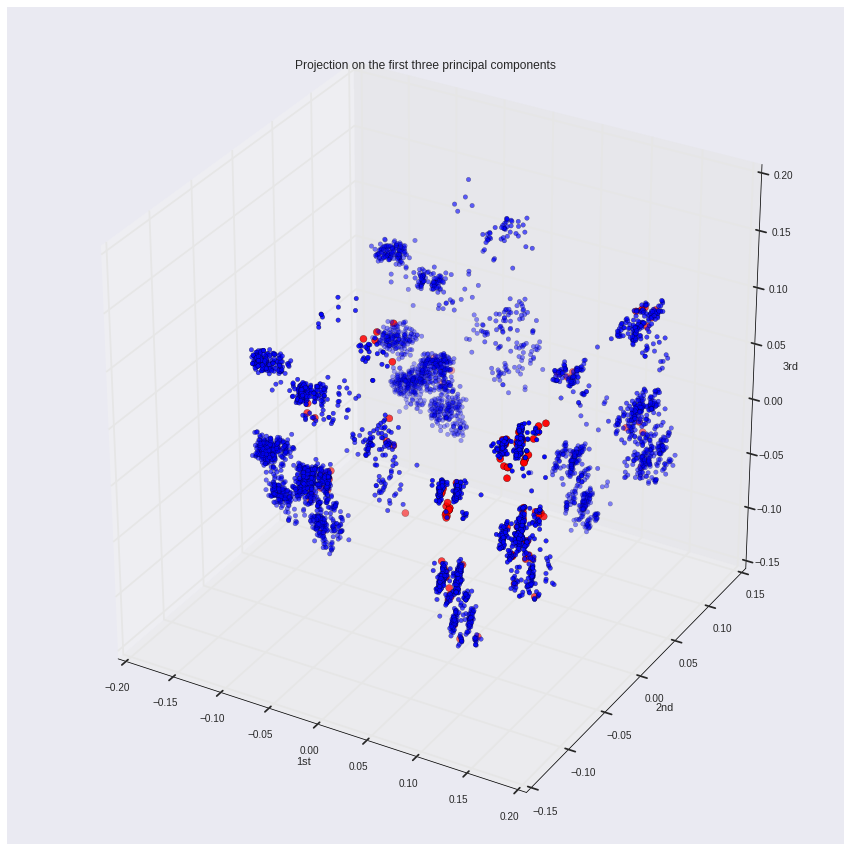

In [47]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Projection on the first three principal components")
ax.set_xlabel("1st")
ax.set_ylabel("2nd")
ax.set_zlabel("3rd")
ax.scatter(pcaed_negatives[:, 0], pcaed_negatives[:, 1], pcaed_negatives[:, 2])
_ = ax.scatter(pcaed_positives[:, 0], pcaed_positives[:, 1], pcaed_positives[:, 2],
               c='Red', s=50)

The conclusion is that there are clusters with high concentration of known geroprotectors and low concentration of unlabeled compounds. Unlabeled compounds from such clusters are potential geroprotectors.

# Splitting Data, Feature Engineering, and Feature Selection

In [48]:
X = sample[:, :-1]
y = sample[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=361)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3855, 2048), (1286, 2048), (3855,), (1286,))

In [49]:
np.sum(y_train) / y_train.shape[0], np.sum(y_test) / y_test.shape[0]

(0.027496757457846951, 0.027216174183514776)

To generate PCA-based features, `y_test` can not be used and `X_test` can be transformed, but it is better to avoid fitting PCA to it.

In [50]:
scores = {}
for i in range(X_train.shape[1]):
    scores[i] = roc_auc_score(y_train, X_train[:, i])
weights = np.array([abs(scores[key] - 0.5) for key in scores.keys()])
weighted_X_train = X_train * weights
weighted_X_test = X_test * weights

In [51]:
pca = PCA(n_components=50, random_state=361)
pca.fit(weighted_X_train)
evr = pca.explained_variance_ratio_

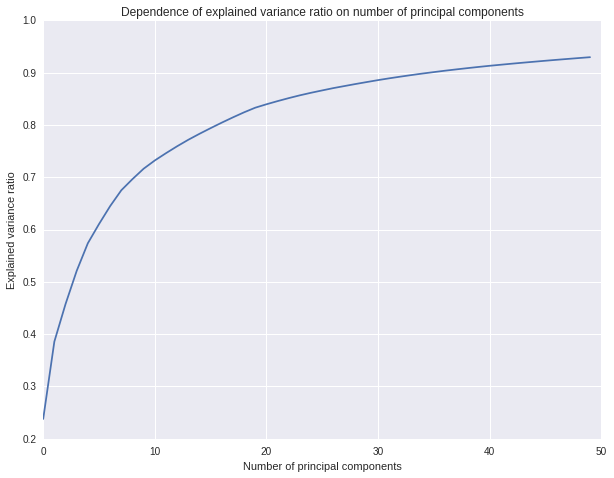

In [52]:
fig = plt.figure(figsize=(10, 7.5))
ax = fig.add_subplot(111)
ax.set_title("Dependence of explained variance ratio on number of principal components")
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Explained variance ratio")
_ = ax.plot(evr.cumsum())

Thus, the most informative components are the first three components. However, they explain not so much variance and because of this it is better to include the first 20 components. 

In [53]:
pca = PCA(n_components=20, random_state=361)
pcaed_X_train = pca.fit_transform(weighted_X_train)
pcaed_X_test = pca.transform(weighted_X_test)

In [54]:
for i in range(3):
    raw_train = roc_auc_score(y_train, pcaed_X_train[:, i])
    raw_test = roc_auc_score(y_test, pcaed_X_test[:, i])
    print "Univariate ROC-AUC for component {}; train: {}, test: {}".format(
        i, max(raw_train, 1 - raw_train), max(raw_test, 1 - raw_test))

Univariate ROC-AUC for component 0; train: 0.704572791738, test: 0.738563434966
Univariate ROC-AUC for component 1; train: 0.776453595173, test: 0.775653762704
Univariate ROC-AUC for component 2; train: 0.608310643845, test: 0.643439534087


These univariate benchmarks look quite decent, but not perfect. Anyway, this is enough to include the corresponding features.

Now filter the less relevant initial features based on Pearson's $\chi^2$-test. It is appropriate here, because features are Boolean.

How to choose a number of features to be selected? There is a heuristic that it is desirable to have at least 30 observations per each independent variable. Given 20 principal components and approximately 5100 training examples, an estimation of number of features is: $$(0.8 \times 0.75 \times 5100) \,/ \, 30 - 20 \approx 80,$$ where factors in numerator adjust for train-test splitting and cross-validation.

In [55]:
feature_selector = SelectKBest(chi2, k=80)
subspaced_X_train = feature_selector.fit_transform(X_train, y_train)
subspaced_X_test = feature_selector.transform(X_test)

In [56]:
fs_and_pca_X_train = np.hstack((subspaced_X_train, pcaed_X_train))
fs_and_pca_X_test = np.hstack((subspaced_X_test, pcaed_X_test))
fs_and_pca_X_train.shape, fs_and_pca_X_test.shape, y_train.shape, y_test.shape

((3855, 100), (1286, 100), (3855,), (1286,))

In [57]:
all_and_pca_X_train = np.hstack((X_train, pcaed_X_train))
all_and_pca_X_test = np.hstack((X_test, pcaed_X_test))
all_and_pca_X_train.shape, all_and_pca_X_test.shape, y_train.shape, y_test.shape

((3855, 2068), (1286, 2068), (3855,), (1286,))

Actually, `all_and_pca_X_train` and `all_and_pca_X_test` are not included in this presentation, because PCA-based features are derived from the initial ones by linear transformation and so there is multicollinearity that leads to overfitting.

# Modelling

### General Utilities

In [58]:
class ModelsTuner(object):
    """
    A convenience tool for repetitive
    pieces of code.
    
    Selects not only optimal hyperparameters,
    but also optimal feature subspace, where
    all candidate subspaces are values of
    `X_train_dict`.
    """
    
    def __init__(self, X_train_dict, X_test_dict, y_train, y_test):
        """
        @type X_train_dict: dict-like, (str -> numpy.ndarray)
        @type X_test_dict: dict-like, (str -> numpy.ndarray)
        @type y_train: numpy.ndarray
        @type y_test: numpy.ndarray
        """
        try:
            assert X_train_dict.keys() == X_test_dict.keys()
        except AssertionError:
            raise ValueError("Mismatching dictionaries.")
        self.X_train_dict = X_train_dict
        self.X_test_dict = X_test_dict
        self.y_train = y_train
        self.y_test = y_test
        self.best_subspace_key_ = None
        self.best_params_ = None
        
    def tune(self, clf, grid_params, kf, scoring, verbose=True):
        """
        Tunes `clf` on grid specified by `grid_params`.
        For evaluation `kf` and `scoring` are used.
        
        @type clf: any sklearn classifier
        @type grid_params: dict
        @type kf: any sklearn folds
        @type scoring: string
        @verbose: bool
        """
        grid_search_cv = GridSearchCV(clf, grid_params, cv=kf, scoring=scoring, refit=False)
        subspaces_scores = {}
        subspaces_best_params = {}
        for key, sample in self.X_train_dict.items():
            grid_search_cv.fit(sample, y_train)
            subspaces_scores[key] = grid_search_cv.best_score_
            subspaces_best_params[key] = grid_search_cv.best_params_
            if verbose:
                print "-*- Results for {}".format(key)
                print "Best CV mean score: {}".format(grid_search_cv.best_score_)
                means = grid_search_cv.cv_results_['mean_test_score']
                stds = grid_search_cv.cv_results_['std_test_score']
                print "Detailed results:"
                for mean, std, params in zip(means, stds,
                                             grid_search_cv.cv_results_['params']):
                    print("%0.3f (+/-%0.03f) for %r" % (mean, 2 * std, params))
                print ''
                
        self.best_subspace_key_ = max(subspaces_scores, key=subspaces_scores.get)
        self.best_params_ = subspaces_best_params[self.best_subspace_key_]
        
        if isinstance(clf, SVC):
            self.best_params_['probability'] = True
        clf = clone(clf).set_params(**self.best_params_).fit(
            self.X_train_dict[self.best_subspace_key_], y_train)
        if verbose:
            print "-*- Best feature subspace is {}.".format(self.best_subspace_key_)
            y_hat = clf.predict_proba(self.X_test_dict[self.best_subspace_key_])[:, 1]
            print "-*- Test set score: {}".format(roc_auc_score(self.y_test, y_hat))
        
        return clf

### Benchmark

What scores can be achieved by some popular ensemble method (say, XGBoost with 300 trees) trained on initial binary features?

In [59]:
clf = XGBClassifier(seed=361)
grid_params = {'n_estimators': [300]}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=361)

In [60]:
X_train_dict = OrderedDict([('2048f', X_train)])
X_test_dict = OrderedDict([('2048f', X_test)])

In [61]:
tuner = ModelsTuner(X_train_dict, X_test_dict, y_train, y_test)
clf = tuner.tune(clf, grid_params, kf, 'roc_auc')

-*- Results for 2048f
Best CV mean score: 0.917315491814
Detailed results:
0.917 (+/-0.083) for {'n_estimators': 300}

-*- Best feature subspace is 2048f.
-*- Test set score: 0.926732899395


This is a relatively high score. Is it possible to beat it?

### K-Nearest Neighbors

In [62]:
clf = KNeighborsClassifier()
grid_params = {'n_neighbors': [20, 30, 40, 50],
               'weights': ['uniform', 'distance'],
               'p': [1, 2]}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=361)

Because K-Nearest Neighbors classifier is vulnerable to curse of dimensionality, only few features are used.

In [63]:
X_train_dict = OrderedDict([('{}pc'.format(i), pcaed_X_train[:, :i]) for i in range(1, 11)])
X_test_dict = OrderedDict([('{}pc'.format(i), pcaed_X_test[:, :i]) for i in range(1, 11)])

In [64]:
tuner = ModelsTuner(X_train_dict, X_test_dict, y_train, y_test)
clf = tuner.tune(clf, grid_params, kf, 'roc_auc')

-*- Results for 1pc
Best CV mean score: 0.686025810494
Detailed results:
0.624 (+/-0.071) for {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}
0.612 (+/-0.062) for {'n_neighbors': 20, 'weights': 'distance', 'p': 1}
0.624 (+/-0.071) for {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}
0.612 (+/-0.062) for {'n_neighbors': 20, 'weights': 'distance', 'p': 2}
0.644 (+/-0.075) for {'n_neighbors': 30, 'weights': 'uniform', 'p': 1}
0.628 (+/-0.061) for {'n_neighbors': 30, 'weights': 'distance', 'p': 1}
0.644 (+/-0.075) for {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}
0.628 (+/-0.061) for {'n_neighbors': 30, 'weights': 'distance', 'p': 2}
0.667 (+/-0.067) for {'n_neighbors': 40, 'weights': 'uniform', 'p': 1}
0.639 (+/-0.057) for {'n_neighbors': 40, 'weights': 'distance', 'p': 1}
0.667 (+/-0.067) for {'n_neighbors': 40, 'weights': 'uniform', 'p': 2}
0.639 (+/-0.057) for {'n_neighbors': 40, 'weights': 'distance', 'p': 2}
0.686 (+/-0.058) for {'n_neighbors': 50, 'weights': 'uniform', 'p': 1

### Support Vector Machine

In [65]:
clf = SVC(random_state=361)
grid_params = {'C': [0.5, 1, 2],
               'kernel': ['rbf', 'poly', 'sigmoid'],
               'class_weight': [None, 'balanced']}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=361)

For SVM there are two options: small-to-moderate amount of principal components and all chosen features (both selected from the initial set and engineered). There is no option with absolutely all features, because it is time-consuming (by default, SVC does not predict probabilities and intensive computations are required to do so).

In [66]:
X_train_dict = OrderedDict([('7pc', pcaed_X_train[:, :7]),
                            ('80f_20pc', fs_and_pca_X_train)])
X_test_dict = OrderedDict([('7pc', pcaed_X_test[:, :7]),
                           ('80f_20pc', fs_and_pca_X_test)])

In [67]:
tuner = ModelsTuner(X_train_dict, X_test_dict, y_train, y_test)
clf = tuner.tune(clf, grid_params, kf, 'roc_auc')

-*- Results for 7pc
Best CV mean score: 0.82103040057
Detailed results:
0.585 (+/-0.173) for {'kernel': 'rbf', 'C': 0.5, 'class_weight': None}
0.631 (+/-0.196) for {'kernel': 'poly', 'C': 0.5, 'class_weight': None}
0.557 (+/-0.247) for {'kernel': 'sigmoid', 'C': 0.5, 'class_weight': None}
0.804 (+/-0.027) for {'kernel': 'rbf', 'C': 0.5, 'class_weight': 'balanced'}
0.805 (+/-0.013) for {'kernel': 'poly', 'C': 0.5, 'class_weight': 'balanced'}
0.799 (+/-0.024) for {'kernel': 'sigmoid', 'C': 0.5, 'class_weight': 'balanced'}
0.608 (+/-0.163) for {'kernel': 'rbf', 'C': 1, 'class_weight': None}
0.631 (+/-0.196) for {'kernel': 'poly', 'C': 1, 'class_weight': None}
0.514 (+/-0.249) for {'kernel': 'sigmoid', 'C': 1, 'class_weight': None}
0.811 (+/-0.029) for {'kernel': 'rbf', 'C': 1, 'class_weight': 'balanced'}
0.805 (+/-0.013) for {'kernel': 'poly', 'C': 1, 'class_weight': 'balanced'}
0.803 (+/-0.027) for {'kernel': 'sigmoid', 'C': 1, 'class_weight': 'balanced'}
0.603 (+/-0.281) for {'kernel': 

### Gradient Boosting

Grid is rather coarse than fine, because both implementations from *sklearn* and *xgboost* work slowly on regular laptop.

In [68]:
clf = XGBClassifier(seed=361)
grid_params = {'n_estimators': [200, 300],
               'max_depth': [3, 5],
               'subsample': [0.8, 1],
               'scale_pos_weight': [1, 5, 35]}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=361)

In [69]:
X_train_dict = OrderedDict([('20pc', pcaed_X_train),
                            ('80f', subspaced_X_train),
                            ('80f_20pc', fs_and_pca_X_train),
                            ('2048f', X_train)])
X_test_dict = OrderedDict([('20pc', pcaed_X_test),
                           ('80f', subspaced_X_test),
                           ('80f_20pc', fs_and_pca_X_test),
                           ('2048f', X_test)])

In [70]:
tuner = ModelsTuner(X_train_dict, X_test_dict, y_train, y_test)
clf = tuner.tune(clf, grid_params, kf, 'roc_auc')

-*- Results for 20pc
Best CV mean score: 0.869430339259
Detailed results:
0.863 (+/-0.097) for {'n_estimators': 200, 'scale_pos_weight': 1, 'max_depth': 3, 'subsample': 0.8}
0.865 (+/-0.102) for {'n_estimators': 200, 'scale_pos_weight': 1, 'max_depth': 3, 'subsample': 1}
0.863 (+/-0.102) for {'n_estimators': 200, 'scale_pos_weight': 5, 'max_depth': 3, 'subsample': 0.8}
0.862 (+/-0.096) for {'n_estimators': 200, 'scale_pos_weight': 5, 'max_depth': 3, 'subsample': 1}
0.854 (+/-0.114) for {'n_estimators': 200, 'scale_pos_weight': 35, 'max_depth': 3, 'subsample': 0.8}
0.849 (+/-0.101) for {'n_estimators': 200, 'scale_pos_weight': 35, 'max_depth': 3, 'subsample': 1}
0.866 (+/-0.093) for {'n_estimators': 300, 'scale_pos_weight': 1, 'max_depth': 3, 'subsample': 0.8}
0.862 (+/-0.099) for {'n_estimators': 300, 'scale_pos_weight': 1, 'max_depth': 3, 'subsample': 1}
0.860 (+/-0.105) for {'n_estimators': 300, 'scale_pos_weight': 5, 'max_depth': 3, 'subsample': 0.8}
0.860 (+/-0.093) for {'n_estimat

Model trained on all features has higher cross-validation scores than model trained on selected subspace, but it takes much more time to fit it. Also it is not as transparent as, say, K-Nearest Neighbors run on the three principal components.

In [71]:
y_train_gb = clf.predict_proba(X_train_dict[tuner.best_subspace_key_])[:, 1]
y_test_gb = clf.predict_proba(X_test_dict[tuner.best_subspace_key_])[:, 1]

In [72]:
sorted([(k, v) for k, v in clf.booster().get_score(importance_type='weight').items()],
       key=lambda t: t[1], reverse=True)[:15]

[('f926', 56),
 ('f389', 51),
 ('f378', 44),
 ('f1057', 44),
 ('f1019', 42),
 ('f1199', 41),
 ('f935', 37),
 ('f1399', 37),
 ('f875', 37),
 ('f80', 36),
 ('f1152', 35),
 ('f1979', 33),
 ('f1145', 31),
 ('f650', 30),
 ('f1039', 28)]

In [73]:
sorted([(k, round(v, 2)) for k, v in clf.booster().get_score(importance_type='gain').items()],
       key=lambda t: t[1], reverse=True)[:15]

[('f1380', 37.52),
 ('f137', 33.08),
 ('f1585', 29.69),
 ('f207', 28.58),
 ('f455', 26.44),
 ('f786', 25.89),
 ('f424', 25.86),
 ('f1075', 23.35),
 ('f1489', 21.9),
 ('f1466', 20.66),
 ('f1937', 20.56),
 ('f726', 20.18),
 ('f1879', 19.53),
 ('f944', 19.35),
 ('f406', 19.18)]

The fact that two lists of the most important features are totally different can be used for explanation, why features with poor univariate ROC-AUC can contribute to an overall model. For example, they can provide splits that, in turn, allow having splits that substantially reduce impurity. More generally, they can play their roles only in interaction with other features.

Somehow or other, features with the highest univariate ROC-AUC such as 1152, 378, and 1057 are at the top based on number of splits, but are not at the top based on heterogeneity reduction. Feature 1380 is the most important by gain and it has high univariate ROC-AUC (although it is not in the list of top-10 features by it). At the same time, the majority of features with the highest univariate ROC-AUC have neither top-level weight importance nor top-level gain importance.

### Extra Trees

In [74]:
clf = ExtraTreesClassifier(random_state=361)
grid_params = {'n_estimators': [100, 200, 300],
               'max_depth': [10, None],
               'class_weight': [None, {0: 1, 1: 5}, 'balanced']}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=361)

The same feature subspaces are used for all ensemble methods.

In [75]:
X_train_dict = OrderedDict([('20pc', pcaed_X_train),
                            ('80f', subspaced_X_train),
                            ('80f_20pc', fs_and_pca_X_train),
                            ('2048f', X_train)])
X_test_dict = OrderedDict([('20pc', pcaed_X_test),
                           ('80f', subspaced_X_test),
                           ('80f_20pc', fs_and_pca_X_test),
                           ('2048f', X_test)])

In [76]:
tuner = ModelsTuner(X_train_dict, X_test_dict, y_train, y_test)
clf = tuner.tune(clf, grid_params, kf, 'roc_auc')

-*- Results for 20pc
Best CV mean score: 0.887403107478
Detailed results:
0.887 (+/-0.079) for {'n_estimators': 100, 'max_depth': 10, 'class_weight': None}
0.886 (+/-0.080) for {'n_estimators': 200, 'max_depth': 10, 'class_weight': None}
0.885 (+/-0.084) for {'n_estimators': 300, 'max_depth': 10, 'class_weight': None}
0.846 (+/-0.084) for {'n_estimators': 100, 'max_depth': None, 'class_weight': None}
0.865 (+/-0.091) for {'n_estimators': 200, 'max_depth': None, 'class_weight': None}
0.862 (+/-0.093) for {'n_estimators': 300, 'max_depth': None, 'class_weight': None}
0.886 (+/-0.077) for {'n_estimators': 100, 'max_depth': 10, 'class_weight': {0: 1, 1: 5}}
0.886 (+/-0.073) for {'n_estimators': 200, 'max_depth': 10, 'class_weight': {0: 1, 1: 5}}
0.885 (+/-0.074) for {'n_estimators': 300, 'max_depth': 10, 'class_weight': {0: 1, 1: 5}}
0.864 (+/-0.094) for {'n_estimators': 100, 'max_depth': None, 'class_weight': {0: 1, 1: 5}}
0.865 (+/-0.089) for {'n_estimators': 200, 'max_depth': None, 'cla

In [77]:
y_train_et = clf.predict_proba(X_train_dict[tuner.best_subspace_key_])[:, 1]
y_test_et = clf.predict_proba(X_test_dict[tuner.best_subspace_key_])[:, 1]

In [78]:
sorted(zip(['f{}'.format(i) for i in range(1, 2049)],
           clf.feature_importances_.tolist()),
       key=lambda t: t[1], reverse=True)[:10]

[('f379', 0.023339069363562722),
 ('f1153', 0.02237352511508882),
 ('f1817', 0.020753179644042434),
 ('f1381', 0.013956720554382945),
 ('f1918', 0.012217866666309113),
 ('f1723', 0.011470840345910473),
 ('f1603', 0.01096424771825753),
 ('f1874', 0.010881454599090934),
 ('f1980', 0.010650011238657059),
 ('f1608', 0.010567926579785801)]

Feature importances look different from that of Gradient Boosting. Therefore, it might be a good idea to use stacking running on top of predictions made by these two methods.

### Random Forest

In [79]:
clf = RandomForestClassifier(random_state=361)
grid_params = {'n_estimators': [100, 200, 300],
               'max_depth': [10, None],
               'class_weight': [None, {0: 1, 1: 5}, 'balanced']}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=361)

In [80]:
X_train_dict = OrderedDict([('20pc', pcaed_X_train),
                            ('80f', subspaced_X_train),
                            ('80f_20pc', fs_and_pca_X_train),
                            ('2048f', X_train)])
X_test_dict = OrderedDict([('20pc', pcaed_X_test),
                           ('80f', subspaced_X_test),
                           ('80f_20pc', fs_and_pca_X_test),
                           ('2048f', X_test)])

In [81]:
tuner = ModelsTuner(X_train_dict, X_test_dict, y_train, y_test)
clf = tuner.tune(clf, grid_params, kf, 'roc_auc')

-*- Results for 20pc
Best CV mean score: 0.873308444295
Detailed results:
0.825 (+/-0.099) for {'n_estimators': 100, 'max_depth': 10, 'class_weight': None}
0.848 (+/-0.098) for {'n_estimators': 200, 'max_depth': 10, 'class_weight': None}
0.853 (+/-0.108) for {'n_estimators': 300, 'max_depth': 10, 'class_weight': None}
0.832 (+/-0.126) for {'n_estimators': 100, 'max_depth': None, 'class_weight': None}
0.852 (+/-0.116) for {'n_estimators': 200, 'max_depth': None, 'class_weight': None}
0.858 (+/-0.110) for {'n_estimators': 300, 'max_depth': None, 'class_weight': None}
0.843 (+/-0.109) for {'n_estimators': 100, 'max_depth': 10, 'class_weight': {0: 1, 1: 5}}
0.858 (+/-0.106) for {'n_estimators': 200, 'max_depth': 10, 'class_weight': {0: 1, 1: 5}}
0.858 (+/-0.111) for {'n_estimators': 300, 'max_depth': 10, 'class_weight': {0: 1, 1: 5}}
0.829 (+/-0.118) for {'n_estimators': 100, 'max_depth': None, 'class_weight': {0: 1, 1: 5}}
0.855 (+/-0.126) for {'n_estimators': 200, 'max_depth': None, 'cla

In [82]:
y_train_rf = clf.predict_proba(X_train_dict[tuner.best_subspace_key_])[:, 1]
y_test_rf = clf.predict_proba(X_test_dict[tuner.best_subspace_key_])[:, 1]

In [83]:
sorted(zip(['f{}'.format(i) for i in range(1, 2049)],
           clf.feature_importances_.tolist()),
       key=lambda t: t[1], reverse=True)[:10]

[('f1153', 0.0227133162632017),
 ('f379', 0.02180268393693651),
 ('f1817', 0.019272511204080123),
 ('f1381', 0.013060262627866843),
 ('f1918', 0.012941429429904361),
 ('f1874', 0.011717744700229253),
 ('f1603', 0.010217991219416935),
 ('f1980', 0.009921799329530356),
 ('f1723', 0.009508459373281002),
 ('f936', 0.008964141985206002)]

There is a tie in cross-validation scores of Extra Trees and Random Forest, because the difference is not significant. Both of the methods can be a winner. However, let us decide that Random Forest wins.

# New Potential Geroprotectors

Having a method that wins during cross-validation and demonstrates solid result on the test set, we can fit it to all available data and find unlabeled objects with the highest estimated probability of belonging to the positive class. Refitting to the whole dataset can improve performance, because more data to train is better than less data (of course, if additional data are appropriate).

In [84]:
X_total = sample[:, :-1]
X_total.shape, y.shape

((5141, 2048), (5141,))

In [85]:
selected_params = tuner.best_params_
selected_params['random_state'] = 361
clf = RandomForestClassifier(**selected_params)
clf

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=361, verbose=0, warm_start=False)

In [86]:
clf.fit(X_total, y)
y_hat = clf.predict_proba(X_total)[:, 1]
roc_auc_score(y, y_hat)

1.0

Above value means that Random Forest with passed parameters is capable enough to memorize training data. Anyway, we already know that it has ability to generalize well.

In [87]:
min(y_hat[:border])

0.56666666666666665

In [88]:
max(y_hat[border:])

0.28666666666666668

Naive interpretation is that no one unlabeled compound has probability of being a geroprotecor higher than *0.3*. Of course, this is wrong. Random Forest estimates just a share of trees that classify an object as a positive example. Since unlabeled examples are treated as negative ones, low estimated probabilities (which do not indicate true confidences in predicted labels) should not mislead anyone. The only thing that is important is that the higher estimated probability is, the higher the estimated chances to be a geroprotector are.

To see that low estimated probabilities do not evidence that compound probably is not a geroprotector, let us look at the test set. It contains known geroprotectors, but the highest estimated probabilities are as follows. 

In [89]:
np.sort(y_test_rf)[-int(np.sum(y_test)):][::-1]

array([ 0.82666667,  0.82      ,  0.79      ,  0.73333333,  0.73      ,
        0.73      ,  0.73      ,  0.66333333,  0.61      ,  0.57666667,
        0.52333333,  0.48333333,  0.47      ,  0.45      ,  0.40666667,
        0.39333333,  0.37666667,  0.35333333,  0.35333333,  0.35      ,
        0.33      ,  0.31666667,  0.31      ,  0.29333333,  0.27333333,
        0.26666667,  0.25666667,  0.25333333,  0.25      ,  0.22      ,
        0.21666667,  0.21333333,  0.21333333,  0.20333333,  0.2       ])

There are `int(np.sum(y_test))` known geroprotectors, but some of the highest estimated probabilities are about 20%. Moreover, since ROC-AUC on the test set is less than than 1, there are geroprotectors with even lower estimated probability.

So compounds that often goes to leaves with high concentration of known geroprotectors, are similar to known geroprotectors and may be a geroprotectors too. 

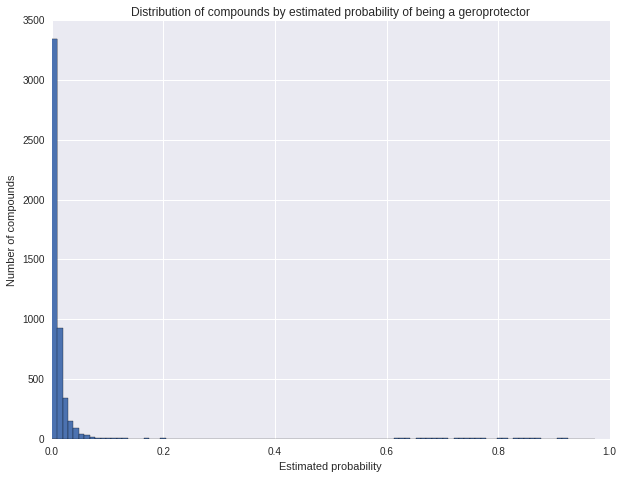

In [90]:
fig = plt.figure(figsize=(10, 7.5))
ax = fig.add_subplot(111)
ax.set_title("Distribution of compounds by estimated probability of being a geroprotector")
ax.set_xlabel("Estimated probability")
ax.set_ylabel("Number of compounds")
_ = ax.hist(y_hat, 100)

Let us find the three unlabeled examples with the highest estimated probabilities of being a geroprotector.

In [91]:
n_examples = 3
indices = y_hat[border:].argsort()[-n_examples:][::-1].tolist()
indices = [x + border for x in indices]
indices

[296, 4881, 1555]

In [92]:
found_candidates = random_smiles.iloc[indices, 0].values.tolist()
found_candidates

['c1cc(ccc1CN2CC[C@H](C2)[N+](=O)[O-])[N+](=O)[O-]',
 'c1cc(c(cc1Cl)OCC(=O)NC[C@H]2CCCO2)Cl',
 'Cc1cccc(c1)Cn2c(c(nn2)C(=O)NCc3ccccc3)N']

You can search by this SMILES using sources such as ChemSpider: http://www.chemspider.com/. Do not forget to remove Python single quotes from SMILES.

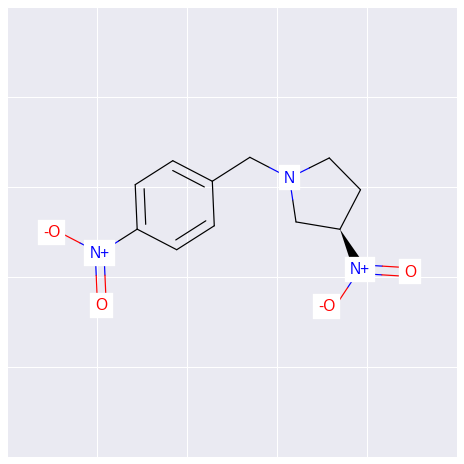

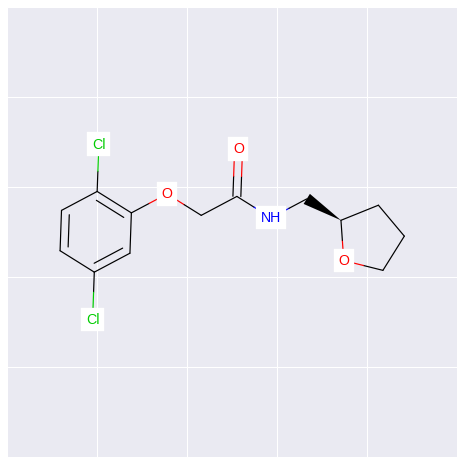

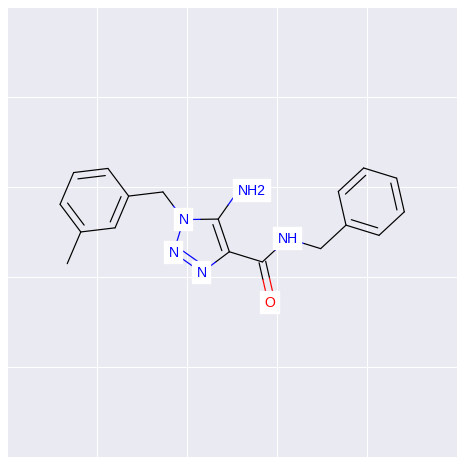

In [93]:
for candidate in found_candidates:
    molecule = MolFromSmiles(candidate)
    Draw.MolToMPL(molecule, size=(250, 250))

# Conclusion

Data analysis is a perspective way to create long-lists of compounds that possess some desired properties. Then candidates from such lists can be tested experimentally. If lists contain predominantly high-quality candidates, costs of searching for new compounds are seriously reduced.

In this presentation machine learning techniques are applied in order to find potential geroprotectors and, finally, a set of three candidates is demonstrated. It is worth to be mentioned that quality scores of algorithms are high and this is an evidence for existence of general chemical or biological rule that describes geroprotectors. Although ensemble methods are black boxes, domain specialists can start from clusters' visualization provided during exploratory analysis. Dimensionality reduction makes data more transparent at the cost of a slight decrease in quality scores.

Further improvements can be achieved, in particular, by introducing new features. For example, it is possible to enrich existing dataset using other sources (e.g. sources on gene expression).

Another way to improve the study lies in revising its methodology. The current methodology can detect unknown geroprotectors that are close enough to known geroprotectors, but it can not detect groups of unknown geroprotectors that are dissimilar to any known geroprotectors. In other words, the current methodology is able to find regularities or rules in geroprotectors distribution, but it can not extend the set of found regularities and rules in order to cover rules for totally unknown groups of geroprotectors.

Finally, some techniques like stacking or blending can be applied in order to incorporate predictions made by several algorithms.